# [Selected Problems in Machine Learning (NPFL097)](https://ufal.mff.cuni.cz/courses/npfl097)

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob

In [3]:
glob("data/*")

['data/dictionary.txt', 'data/test_data.tsv', 'data/training_data.tsv']

In [4]:
train = np.genfromtxt("data/training_data.tsv", delimiter="\t", dtype=np.int32)
test = np.genfromtxt("data/test_data.tsv", delimiter="\t", dtype=np.int32)
dictionary = np.genfromtxt("data/dictionary.txt", dtype=np.string_)

In [5]:
dictionary

array([b'aarp', b'abandon', b'abandoned', ..., b'zogbys', b'zone',
       b'zones'], dtype='|S40')

## Question 1.

**Using the training data, compute the maximum likelihood estimation over the words across
the documents. Plot a histogram showing 20 most probable words.**

The model is just a Multinomial distribution, that is

$$
p(x | \pi, n) = \binom{n!}{x_1!,x_2!,\ldots,x_m!} \prod_{i=1}^m \pi_i^{x_i} = n! \prod_{i=1}^m \frac{\pi_i^{x_i}}{x_i!}
$$

where $\pi_i$ is the probability of $i-th$ word, $x_i$ is the number of occurences of the $i-th$ word, $m$ is the number of words in the dictionary, and $n$ is the total number of occurences.

We compute $\pi_i$ using MLE, that is simply

$$
\pi_i = \frac{x_i}{n}.
$$

In [6]:
m = len(dictionary)

def compute_counts(document):
    counts = np.zeros(m, np.int32)
    
    for document_id, word_id, count in document:
        counts[word_id - 1] += count
        
    return counts

In [7]:
counts = compute_counts(train)
n = counts.sum()

pi_mle = counts.astype(np.float32) / n

Most probable word is simply the one with the highest MLE

In [8]:
dictionary[np.argmax(pi_mle)]

b'bush'

In [9]:
max(counts), max(pi_mle)

(3833, 0.014097198214036146)

In [10]:
max_mle = pi_mle[np.argsort(pi_mle)[-20:]]
most_probable_words = dictionary[np.argsort(pi_mle)[-20:]]

In [11]:
max_mle

array([0.00340937, 0.00342776, 0.00343143, 0.00344615, 0.00352706,
       0.00353441, 0.00384335, 0.00388749, 0.00401989, 0.00432883,
       0.00450537, 0.00468558, 0.00497245, 0.00498716, 0.00534392,
       0.00535863, 0.00570067, 0.00841124, 0.00967642, 0.0140972 ])

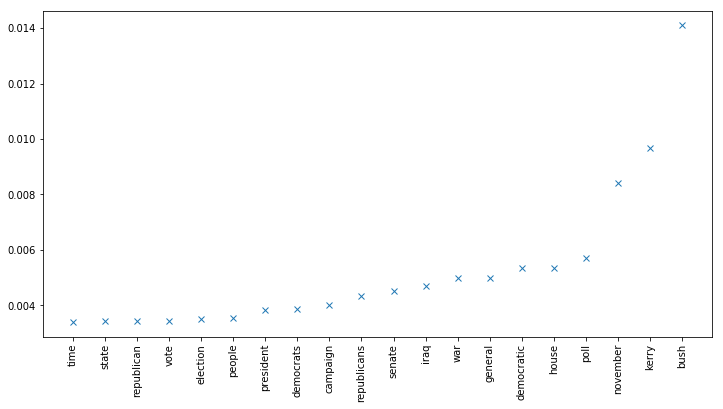

In [12]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
plt.plot(most_probable_words, max_mle, "x")

## Question 2.

**What is the log-probability of the test data if we use the MLE model from question 1)? Note
that the test set contains words which are not contained in the training set. Explain**

The log probability is then

$$
\begin{align}
\log \left( n! \prod_{i=1}^m \frac{\pi_i^{x_i}}{x_i!} \right) &= \log n! + \sum_{i=1}^m x_i \log \pi_i - \sum_{i=1}^m \log x_i! \\
&= \sum_{i=1}^n \log i + \sum_{i=1}^m x_i \log \pi_i - \sum_{i=1}^m \sum_{j=1}^{x_i} \log j
\end{align}
$$

In [13]:
def logfact(k):
    return np.sum(np.log2(np.array(range(int(k)), dtype=np.float32) + 1))

def log_prob(dataset, pi):
    counts = compute_counts(dataset)
    
    return np.sum(counts * np.log2(pi))
    
#     t1 = np.sum(logfact(n))
#     t2 = np.sum(counts * np.log2(pi))
#     t3 = np.sum([logfact(c) for c in counts])

#     return t1 + t2 - t3

In [14]:
log_prob(test, pi_mle)

/home/darth/.venv/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys


-inf

## Question 3.

**Instead of MLE, do the Bayesian inference model on the training data using a symmetric Dirichlet prior with a concentration parameter 0.1. Provide a formula for the predictive distribution.**

I'm not sure what the *predictive distribution* is in this context, since it could be either for the Dirichlet-Categorical or the Dirichlet-Multinomial, so I'm going to provide both :)

In general, posterior predictive is

$$
p(X | D) = \int p(X|\theta) p(\theta|D)\ d\theta
$$

For Dirichlet-Categorical ($Dir(\alpha + D)$ means the posterior for $p(\alpha|D)$, which for Dirichlet-Categorical is just adding the psuedo-counts together, where $D$ are the pseudo-counts, $\boldsymbol\pi$ is the Categorical probabilities, $\boldsymbol\alpha$ are the concentrations).

$$
\begin{align}
p(X=j | D) &= \int p(X=j|\boldsymbol\pi) p(\boldsymbol\pi|D)\ d\pi \\
&= \int Cat(X=j|\boldsymbol\pi) p(\boldsymbol\pi|D)\ d\pi \\
&= \int \boldsymbol\pi_j p(\boldsymbol\pi|D) \ d\pi 
\end{align}
$$

splitting the integral into $\pi_{\neg j} = (\pi_1, \ldots, \pi_{j-1},\pi_{j+1},\ldots, \pi_m)$ and $\pi_j$ and writing it as a double integral

$$
\begin{align}
&= \int \int \boldsymbol\pi_j p(\boldsymbol\pi|D) \ d\pi_{\neg j}\ d\pi_j \\
&= \int \pi_j \int p(\boldsymbol\pi|D) \ d\pi_{\neg j}\ d\pi_j \\
&= \int \pi_j p(\pi_j) d\pi_j
\end{align}
$$

where the last equation is simply because of marginalization. This is simply 

$$
E[\pi_j | D] = \frac{\alpha_j + x_j}{\sum_{i=1}^m (\alpha_i + x_i)}
$$

**In any case, I'll simply assume the Dirichlet-Categorical case in the rest of the code.**

In [15]:
def dirichlet_categorical_posterior(dataset, alpha):
    counts = compute_counts(dataset)
    n = counts.sum()

    return (counts + alpha) / (n + m*alpha)

In [16]:
pi_posterior = dirichlet_categorical_posterior(train, 0.1)
pi_posterior

array([1.50409812e-05, 6.27318971e-05, 4.80577691e-05, ...,
       6.27318971e-05, 1.17759877e-04, 2.23780452e-05])

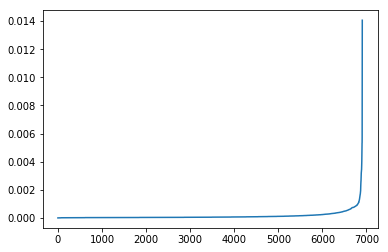

In [17]:
plt.plot(np.sort(pi_posterior))

## Question 4:

**Using the Bayesian model from question 3, compute the log probability and the per-word perplexity of the test data.**

In [18]:
print(f"Train log P = {log_prob(train, pi_posterior)}")
print(f"Test log P = {log_prob(test, pi_posterior)}")

Train log P = -3081803.2292384217
Test log P = -2231753.5169690647


$$
\exp\left(-\log p(data) / n\right) = \exp\left(-\log \prod_{i=1}^m \pi_i^{x_i} / n\right) = \exp\left(-\sum_{i=1}^m x_i \log \pi_i / n \right)
$$

In [19]:
def per_word_perplexity(dataset, pi):
    counts = compute_counts(dataset)
    n = counts.sum()
        
    logp = log_prob(dataset, pi)

    return 2**(- logp / n)

In [20]:
print(f"Per word perplexity = {per_word_perplexity(test, pi_posterior)}")

Per word perplexity = 2697.1068182222193


# Question 5:

**Compute the per-word perplexity of the test data using uniform multinomial dictribution
over the dictionary. Compare this value to the previously computed perplexities and explain.**

In [21]:
pi_uniform = np.array([1/len(dictionary) for _ in range(len(dictionary))])

print(f"Uniform prior perplexity = {per_word_perplexity(test, pi_uniform)}")

Uniform prior perplexity = 6905.99999999999


In the uniform case we get exactly

$$
2^{-\log 1/m} = \frac{1}{2^{\log 1/m}} = m
$$

which is the size of the dictionary.

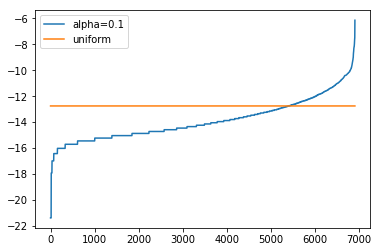

In [22]:
plt.plot(np.log2(np.sort(pi_posterior)), label="alpha=0.1")
plt.plot(np.log2(np.sort(pi_uniform)), label="uniform")
plt.legend()

## Question 6:

**Implement the Latent Dirichlet allocation topic model as described in the previous lectures.
Set the hyperparameters α = 0.1, γ = 0.1 and set number of topics K = 20. Plot the topic
posteriors of the document 1 as a function of the number of Gibbs sweeps, up to 20 sweeps.
Comment on these.**

The general model parameters:

- $D$ is the number of documents.
- $m$ is the number of unique words in the dictionary.
- $N_d$ is the number of words in document $D$, these are not the same.
- $K$ is the number of topics, fixed at $20$.
- $\alpha$ and $\gamma$ are prior parameters set both at fixed $0.1$ for a symmetric Dirichlet
- $z_{nd}$ assigns a topic to each position $n$ in document $d$. This can't be a matrix since the documents have varying length.
- $w_{nd}$ assigns a word to each position $n$ in document $d$. These are drawn from the distribution for $\beta_{z_{nd}}$

and the counters:

- $c_{kd}$ ... number of words assigned (total counts) to topic $k$ in document $d$.
- $c_{km}$ ... number of times a word $m$ is assigned to topic $k$.
- $c_k$ ... number of words assigned (total counts) to topic $k$ across all documents.

In [55]:
D = len(np.unique(train[:,0]))

# Number of word positions in each document
N_D = np.zeros((D,), dtype=np.int32)

for document_id, word_id, count in train:
    N_D[document_id - 1] += count

Each document has different size, which makes things a bit more complicated implementation wise.

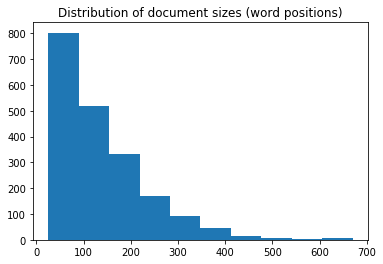

In [56]:
plt.title("Distribution of document sizes (word positions)")
plt.hist(N_D)
plt.show()

In [57]:
K = 20
alpha = 0.1
gamma = 0.1
n_iter = 20
M = len(dictionary)

z_ND = [np.random.randint(0, K, size=N_D[d]) for d in range(D)]

# z_ND = np.random.randint(0, K, size=n*d)
c_KD = np.zeros((K, D), dtype=np.int)
c_KM = np.zeros((K, M), dtype=np.int)
c_K = np.zeros((K,), dtype=np.int)

alpha = 0.1
gamma = 0.1

counts = np.zeros(m, np.int32)

In [50]:


for d, m, count in document:
    word_id -= 1
    
    
    
    counts[word_id - 1] += count

for i in range(n_iter):
    for d in range(D):
        for n in range(N[d]):
            z_nd = # ...
            w_nd = # ...
            
            c_KD[z_nd, d] -= 1
            c_KM[z_nd, w_nd] -= 1
            c_K[z_nd] -= 1

            for k in range(K):
                a = (alpha + c_KD[k, d]) / (K * alpha + N_d - 1)
                b = (gamma + c_MD[k, w_nd]) / (M * gamma + c_K[k])
                p[k] = a*b
                # ... dirichlet update
                
            k = np.random.choice(range(len(p)), p=p) # sample k
            
            z_nd = k
            
            c_KD[k, d] += 1
            c_KM[k, w_nd] += 1
            c_K[k] += 1
            

SyntaxError: invalid syntax (<ipython-input-50-83840fa5fec8>, line 29)